In [ ]:
# albumentations library for segmentation preprocessing. We can see that it is imported as smp
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
# Mounting google drive with dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip dataset
!unzip /content/drive/MyDrive/DATASET/archive.zip -d data/

Archive:  /content/drive/MyDrive/DATASET/archive.zip
  inflating: data/label_class_dict.csv  
  inflating: data/metadata.csv       
  inflating: data/png/test/22828930_15.png  
  inflating: data/png/test/22828990_15.png  
  inflating: data/png/test/22829050_15.png  
  inflating: data/png/test/23429020_15.png  
  inflating: data/png/test/23429080_15.png  
  inflating: data/png/test/23578960_15.png  
  inflating: data/png/test/23579005_15.png  
  inflating: data/png/test/23729035_15.png  
  inflating: data/png/test/23879080_15.png  
  inflating: data/png/test/24179065_15.png  
  inflating: data/png/test_labels/22828930_15.png  
  inflating: data/png/test_labels/22828990_15.png  
  inflating: data/png/test_labels/22829050_15.png  
  inflating: data/png/test_labels/23429020_15.png  
  inflating: data/png/test_labels/23429080_15.png  
  inflating: data/png/test_labels/23578960_15.png  
  inflating: data/png/test_labels/23579005_15.png  
  inflating: data/png/test_labels/23729035_15.png  
  

In [ ]:
# Import library
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import preprocess 
import os 
import pandas as pd 
import dataset as ds 
import numpy as np  
import random  
import sys 
sys.path.insert(0, '/content/')
import segmentation_models_pytorch as smp


In [ ]:
# Directory paths for dataset
DATA_DIR = '/content/data/tiff/'
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [ ]:
# rgb value for all the classes in the dataset
class_dict = pd.read_csv('/content/data/'+"label_class_dict.csv")
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()
print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
# rgb value for classes that we are going to predict i.e background and building
select_classes = ['background', 'building']
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]
print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


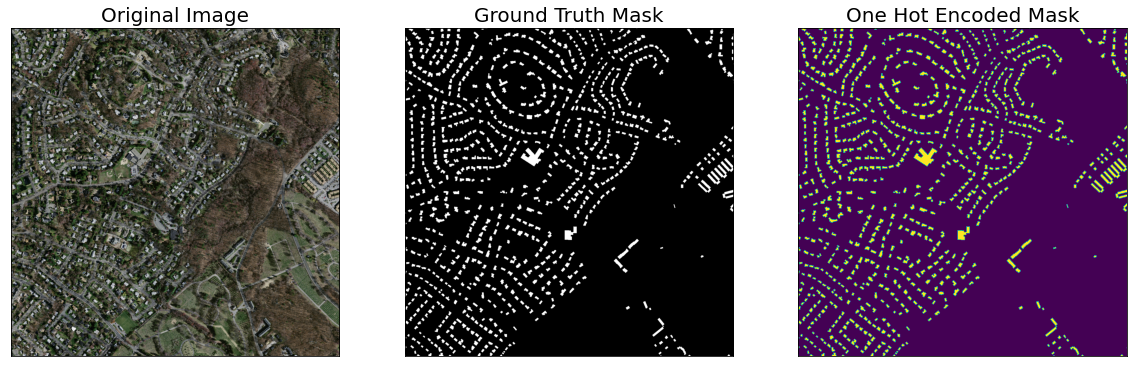

In [ ]:
# dataset visualization
dataset = ds.BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values = select_class_rgb_values)
random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[random_idx]

preprocess.visualize(
    original_image = image,
    ground_truth_mask = preprocess.colour_code_segmentation(preprocess.reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = preprocess.reverse_one_hot(mask)
)

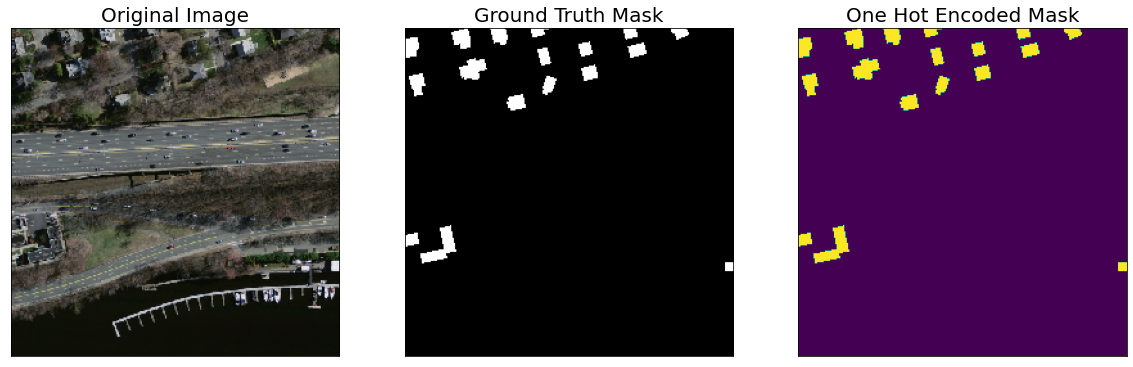

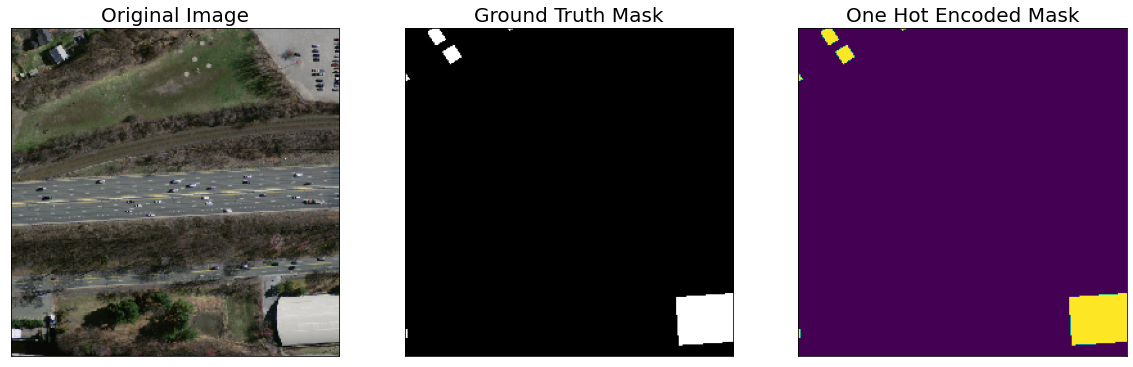

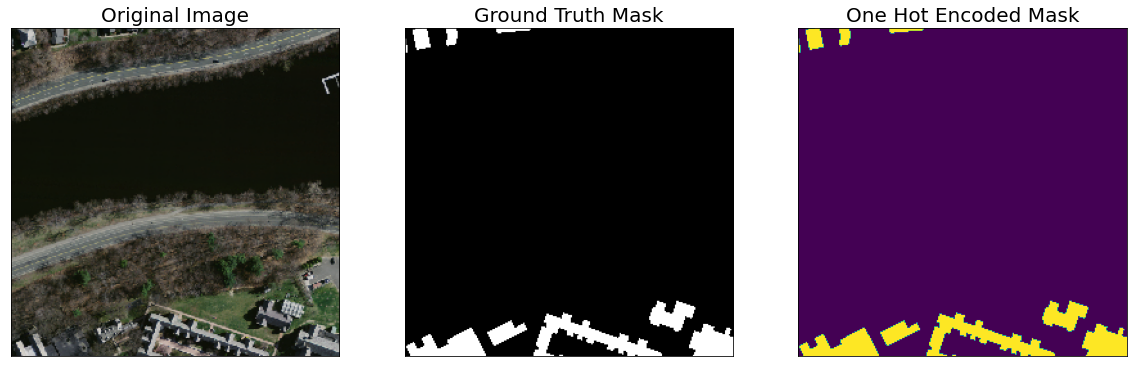

In [ ]:
# dataset augmentation

augmented_dataset = ds.BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation = ds.get_training_augmentation(),
    class_rgb_values = select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset) - 1)

for i in range(3):
    image, mask = augmented_dataset[random_idx]
    preprocess.visualize(
        original_image = image,
        ground_truth_mask = preprocess.colour_code_segmentation(preprocess.reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = preprocess.reverse_one_hot(mask)
    )


In [ ]:
import model_helper as model
import importlib
importlib.reload(model)
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' 

In [ ]:
# unet architecture base parameters
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model_unet.initialize_basemodel(smp.Unet,len(CLASSES))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# model fit with required input and output
model_unet.fit(x_train_dir, y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# different loss functions
import loss as lossfile
importlib.reload(lossfile)

TRAINING = True

EPOCHS = 50

loss = lossfile.TverskyLoss(0.6,0.1)

metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

optimizer = torch.optim.Adam
lr = 0.0001

In [ ]:
# training the model
model_unet.train(EPOCHS,loss,metrics,optimizer,lr,None,'tversky_loss')


Epoch: 0
train:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.461, iou_score - 0.3287]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.4432, iou_score - 0.589]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.4297, iou_score - 0.6444]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.4219, iou_score - 0.7191]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.4213, iou_score - 0.7179]

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it, <bound method TverskyLoss.__name__ of TverskyLoss()> - 0.4154, iou_score - 0.7641]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, <bound m

In [ ]:
import utils
importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [ ]:
factor_dict = utils.parse_loss_factor('/content/custom_loss1_iou.txt')

In [ ]:
factor_dict

{'bce_loss.pth': 0.32687016164724225,
 'log_cos_dice_loss.pth': 0.3346381697931814,
 'tversky_loss.pth': 0.3384916685595763}

In [ ]:
# loss function 1
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model_unet.initialize_basemodel(smp.Unet,len(CLASSES))
model_unet.fit(x_train_dir, y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import loss as lossfile
importlib.reload(lossfile)

TRAINING = True

EPOCHS = 80

loss = lossfile.CustomLoss1(factor_dict['tversky_loss.pth'],factor_dict['log_cos_dice_loss.pth'],factor_dict['bce_loss.pth'])

metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

optimizer = torch.optim.Adam
lr = 0.0001

In [ ]:
model_unet.train(EPOCHS,loss,metrics,optimizer,lr,None,'custom_loss1')


Epoch: 0
train:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.5428, iou_score - 0.1877]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.4985, iou_score - 0.3714]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.4295, iou_score - 0.5062]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3819, iou_score - 0.606]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3805, iou_score - 0.6662]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3649, iou_score - 0.7277]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<00:00,  1.14

In [ ]:
import loss as lossfile
importlib.reload(lossfile)

TRAINING = True

EPOCHS = 100

loss = lossfile.CustomLoss1(factor_dict['tversky_loss.pth'],factor_dict['log_cos_dice_loss.pth'],factor_dict['bce_loss.pth'])

metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

optimizer = torch.optim.Adam
lr = 0.0001

In [ ]:
model_unet.train(EPOCHS,loss,metrics,optimizer,lr,None,'custom_loss12')


Epoch: 0
train:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.4356, iou_score - 0.3377]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.409, iou_score - 0.4947]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.386, iou_score - 0.5839]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3616, iou_score - 0.6556]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3609, iou_score - 0.6255]

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.3572, iou_score - 0.625]

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLo

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/pytho

valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2678, iou_score - 0.8341]
Model saved!

Epoch: 19
valid: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2625, iou_score - 0.8386]
Model saved!

Epoch: 20
valid: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2613, iou_score - 0.8385]

Epoch: 21
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2644, iou_score - 0.8391]
Model saved!

Epoch: 22
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2587, iou_score - 0.8375]

Epoch: 23
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.2553, iou_score - 0.8461]
Model saved!

Epoch: 24
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method

In [ ]:
model_unet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model_unet.initialize_basemodel(smp.Unet,len(CLASSES))
model_unet.fit(x_train_dir, y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import loss as lossfile
importlib.reload(lossfile)

TRAINING = True

EPOCHS = 200

loss = lossfile.CustomLoss1(factor_dict['tversky_loss.pth'],factor_dict['log_cos_dice_loss.pth'],factor_dict['bce_loss.pth'])

metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

optimizer = torch.optim.Adam
lr = 0.0001

In [ ]:
model_unet.train(EPOCHS,loss,metrics,optimizer,lr,None,'custom_loss13')


Epoch: 0
train:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid ins

valid:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.481, iou_score - 0.2394]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.4537, iou_score - 0.3046]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.4391, iou_score - 0.3474]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.425, iou_score - 0.392]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.4105, iou_score - 0.4474]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it, <bound method CustomLoss1.__name__ of CustomLoss1()> - 0.4015, iou_score - 0.4886]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<00:00,  1.17s/

In [ ]:
#@title Model training with ensemble technique

In [ ]:
#@title Resnet with Unet

In [ ]:
import model_helper as model
import importlib
importlib.reload(model)
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' 

In [ ]:
model_unet_resnet = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model_unet_resnet.initialize_basemodel(smp.Unet,len(CLASSES))

In [ ]:
model_unet_resnet.fit(x_train_dir, y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import loss as lossfile
importlib.reload(lossfile)

TRAINING = True

EPOCHS = 100

loss = lossfile.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

optimizer = torch.optim.Adam
lr = 0.0001

In [ ]:
model_unet_resnet.train(EPOCHS,loss,metrics,optimizer,lr,None,'DiceLossResnet-1')


Epoch: 0
train:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.6503, iou_score - 0.08702]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.5657, iou_score - 0.3362]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.4994, iou_score - 0.5495]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.4715, iou_score - 0.655]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.4563, iou_score - 0.6821]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.4392, iou_score - 0.7394]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method DiceLoss.__name

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/qu

valid: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.1268, iou_score - 0.8557]
Model saved!

Epoch: 76
valid: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.1279, iou_score - 0.8519]

Epoch: 77
valid: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.1257, iou_score - 0.8543]

Epoch: 78
valid: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.1212, iou_score - 0.8594]
Model saved!

Epoch: 79
valid: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.1185, iou_score - 0.8619]
Model saved!

Epoch: 80
valid: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.1167, iou_score - 0.8623]
Model saved!

Epoch: 81
valid: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 

In [ ]:
#@title Vgg16 with Unet

In [ ]:
ENCODER = 'vgg16'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' 

In [ ]:
model_unet_vgg = model.Segmodel(ENCODER,ENCODER_WEIGHTS,ACTIVATION)
model_unet_vgg.initialize_basemodel(smp.Unet,len(CLASSES))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_unet_vgg.fit(x_train_dir, y_train_dir,x_valid_dir, y_valid_dir,select_class_rgb_values)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import loss as lossfile
importlib.reload(lossfile)

TRAINING = True

EPOCHS = 100

loss = lossfile.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

optimizer = torch.optim.Adam
lr = 0.0001

In [ ]:
model_unet_vgg.train(EPOCHS,loss,metrics,optimizer,lr,None,'DiceLossVgg-2')


Epoch: 0
train:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.503, iou_score - 0.3794]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.4132, iou_score - 0.6135]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.3537, iou_score - 0.6921]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.3206, iou_score - 0.7395]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.3068, iou_score - 0.7559]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, <bound method DiceLoss.__name__ of DiceLoss()> - 0.2824, iou_score - 0.7938]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, <bound method DiceLoss.__name_

In [ ]:
#Ensemble technique 2 training and testing

In [ ]:
import model_helper as model
import importlib
importlib.reload(model)
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' 

In [ ]:
preprocessing_fn1 = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
model_file1 = '/content/drive/MyDrive/CV-MODELS/DiceLossResnet-1.pth'

In [ ]:
import model_helper as model
import importlib
importlib.reload(model)
ENCODER = 'vgg16'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' 

In [ ]:
preprocessing_fn2 = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
model_file2 = '/content/drive/MyDrive/CV-MODELS/DiceLossVgg-2.pth'

In [ ]:
importlib.reload(model)
name = "/content/drive/MyDrive/CV-MODELS/DICELOSS+VGG+RESNET2"
model.save_prediction(model_file1,model_file2,x_train_dir, y_train_dir,preprocessing_fn1,preprocessing_fn2,select_class_rgb_values,name)

Loaded UNet model from this run.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
importlib.reload(model)
name = "/content/drive/MyDrive/CV-MODELS/DICELOSS+VGG+RESNET2"
model.save_prediction_test(model_file1,model_file2,x_test_dir, y_test_dir,preprocessing_fn1,preprocessing_fn2,select_class_rgb_values,name)

Loaded UNet model from this run.


In [ ]:
x = np.load('/content/drive/MyDrive/CV-MODELS/DICELOSS+VGG+RESNET2_predictions_targets_train.npy')

In [ ]:
y = np.load('/content/drive/MyDrive/CV-MODELS/DICELOSS+VGG+RESNET2_predictions_targets_test.npy')

In [ ]:
print(x.shape,y.shape)

(137, 3, 256, 256, 2) (10, 3, 256, 256, 2)


In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []
for query in x:
  img_one = query[0].ravel()
  img_two = query[1].ravel()
  gt_mask = query[2].ravel()
  x_train.append(img_one+img_two)
  y_train.append(gt_mask)

for query in y:
  img_one = query[0].ravel()
  img_two = query[1].ravel()
  gt_mask = query[2].ravel()
  x_test.append(img_one+img_two)
  y_test.append(gt_mask)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(137, 131072) (137, 131072) (10, 131072) (10, 131072)


In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [ ]:
xgb_estimator = xgb.XGBClassifier(objective='binary:logistic') 
multilabel_model = MultiOutputClassifier(xgb_estimator) 
multilabel_model.fit(x_train, y_train) 

In [ ]:
y_pred = model.predict(x_test) 

In [ ]:
from sklearn.metrics import accuracy_score
print("ACCURACY SCORE  : \n",accuracy_score(y_test,y_pred))
print("IOU SCORE : ",model.get_iou_score(y_test,y_pred))

IOU SCORE :  0.7880663364023271
ACCURACY SCORE :  0.8558663364023271
